In [1]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jre-headless
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 28.2 MB of archives.
After this operation, 104 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u275-b01-0ubuntu1~18.04 [28.2 MB]
Fetched 28.2 MB in 2s (16.2 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u275-b01-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u275-b01-0ubuntu1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u275-b01-0ubunt

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
df_train = spark.read.csv("/content/sample_data/test.csv",inferSchema="true", header="true")
df_train = df_train.withColumnRenamed('TARGET','label')

In [5]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=[column for column in list(set(df_train.columns)) if column !='label'],outputCol="indexedFeatures",numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

In [6]:
# Split the data into training and test sets (30% held out for testing)
trainingData, testData = df_train.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10, maxDepth=5)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher, rf])

In [7]:
model = pipeline.fit(trainingData)

KeyboardInterrupt: ignored

In [ ]:
predictions = model.transform(trainingData)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))

# test data 
# auc = 0.9644788386204777 (numfeature = 20)(numTrees = 100)
# auc = 0.9714285714285714 (numfeature = 30)(numTrees = 100)
# auc = 0.969568670576735 (numfeature = 50)(numTrees = 100)
# auc = 0.9550669216061186 (numfeature = 20)(numTrees = 100)
# auc = 0.9751381215469613 (numfeature = 30)(numTrees = 10)
# auc = 0.9618418877593191 (numfeature = 50)(numTrees = 10)
# training data
# auc = 0.9643255295429208 (numfeature = 20)(numTrees = 100)
# auc = 0.967504494420135 (numfeature = 30)(numTrees = 100)
# auc = 0.9557507980757171 (numfeature = 50)(numTrees = 100)
# auc = 0.9647058823529412 (numfeature = 20)(numTrees = 10)
# auc = 0.9621684867394696 (numfeature = 30)(numTrees = 10)
# auc = 0.9586225104019261 (numfeature = 50)(numTrees = 10)

auc = 0.9124202165806081


In [ ]:
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 1234)  # use 3+ folds in practice

In [ ]:
cvModel = crossval.fit(df_train)

In [ ]:
predictionsDf = cvModel.transform(df_train)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictionsDf)
print("auc = " +str(auc))

auc = 0.5


numTrees -  10
maxDepth -  25


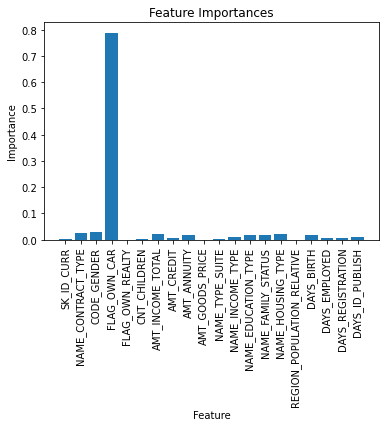

In [ ]:
import matplotlib.pyplot as plt
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')


print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter=5, regParam=0.03)
pipeline = Pipeline(stages=[labelIndexer, hasher, lr])
lrModel = pipeline.fit(trainingData)
predictions = lrModel.transform(trainingData)

In [ ]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))


auc = 0.6762603987378084


optimize

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [int(x) for x in np.linspace(start = 5, stop = 20, num = 3)]) \
    .addGrid(lr.regParam, [x for x in np.linspace(start = 0.01, stop = 0.5, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
              estimatorParamMaps=paramGrid,
              evaluator=BinaryClassificationEvaluator(),
              numFolds=3,
              seed = 1234)

In [ ]:
cvModel = crossval.fit(df_train)
predictionsDf = cvModel.transform(df_train)
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictionsDf)
print("auc = " +str(auc))

auc = 0.7885597548518897


In [ ]:
import matplotlib.pyplot as plt
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]
print('maxIter - ', bestModel.getOrDefault('maxIter'))
print('regParam - {:1.15f}'.format(bestModel.getOrDefault('regParam')))

maxIter -  20
regParam - 0.255000000000000


In [ ]:
feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

weights = bestModel.coefficients
weight = [float(w) for w in weights]

In [ ]:
import pandas as pd
weight_df = pd.DataFrame(list(zip(feature_list,weight)))
weight_df[1] = weight_df[1].apply(lambda x: '%.10f' % x)

In [ ]:
weight_df

,0,1
0,SK_ID_CURR,0.0999466072
1,NAME_CONTRACT_TYPE,0.0000011429
2,CODE_GENDER,0.0000228074
3,FLAG_OWN_CAR,0.0000956770
4,FLAG_OWN_REALTY,0.0000000000
5,CNT_CHILDREN,-0.0338893722
6,AMT_INCOME_TOTAL,-0.0000002203
7,AMT_CREDIT,-0.1057199164
8,AMT_ANNUITY,-0.0254591270
9,AMT_GOODS_PRICE,-0.2264776163


Gradient Tree boosting

In [25]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)
pipeline = Pipeline(stages=[labelIndexer, hasher, gbt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

In [26]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))


auc = 0.9539210461762293


Optimize

In [27]:
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .addGrid(gbt.maxIter, [x for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
              estimatorParamMaps=paramGrid,
              evaluator=BinaryClassificationEvaluator(),
              numFolds=3,
              seed = 1234)

In [28]:
cvModel = crossval.fit(df_train)
predictionsDf = cvModel.transform(df_train)
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC",)
auc = evaluator.evaluate(predictionsDf)
print("auc = " +str(auc))

auc = 0.9863638030312217


In [29]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('maxIter - ',bestModel.getOrDefault('maxIter'))

maxDepth -  10
maxIter -  5


Text(0.5, 1.0, 'Feature Importances')

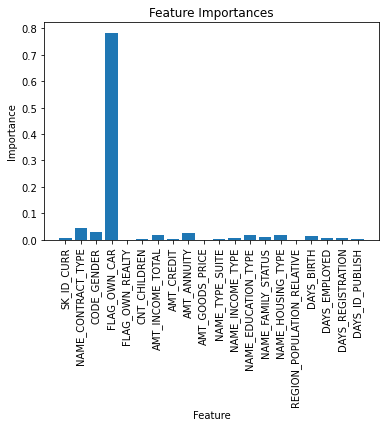

In [30]:
import matplotlib.pyplot as plt
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

ensemble the models - weighted voting

Models with optimized parameters

general

In [31]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

In [32]:
df_train = spark.read.csv("/content/sample_data/test.csv",inferSchema="true", header="true")
df_train = df_train.withColumnRenamed('TARGET','label')
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=[column for column in list(set(df_train.columns)) if column !='label'],outputCol="indexedFeatures",numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

RF

In [33]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees = 10, maxDepth = 25)
pipeline_rf = Pipeline(stages=[labelIndexer, hasher, rf])
model_rf = pipeline_rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)

LR

In [34]:
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures",maxIter = 20, regParam = 0.0255)
pipeline_lr = Pipeline(stages=[labelIndexer, hasher, lr])
model_lr = pipeline_lr.fit(trainingData)
predictions_lr = model_lr.transform(testData)

GBT

In [35]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter = 10, maxDepth = 5)
pipeline_gbt = Pipeline(stages=[labelIndexer, hasher, gbt])
model_gbt = pipeline_gbt.fit(trainingData)
predictions_gbt = model_gbt.transform(testData)

Weighting

In [164]:
w_0 = [1/3,1/3,1/3]
w_1 = [0.2, 0.2, 0.6]
w_2 = [0.6, 0.2, 0.2]
w_3 = [0.2, 0.6, 0.2]
w_4 = [0.7, 0.1, 0.2]

Ensemble the model

In [41]:
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_rf = evaluator.evaluate(predictions_rf)
auc_lr = evaluator.evaluate(predictions_lr)
auc_gbt = evaluator.evaluate(predictions_gbt)
print("auc = " +str(auc_rf))
print("auc = " +str(auc_lr))
print("auc = " +str(auc_gbt))

# auc = 0.9485476353608919
# auc = 0.9053784860557769
# auc = 0.9539210461762293

auc = 0.9485476353608919
auc = 0.9053784860557769
auc = 0.9539210461762293


In [204]:
# to pd df to do weighting computation
rf_pd = predictions_rf.toPandas()
lr_pd = predictions_lr.toPandas()
gbt_pd = predictions_gbt.toPandas()

In [205]:
rf_pd['probability'] = rf_pd['probability'] * w_0[0]
lr_pd['probability'] = lr_pd['probability'] * w_0[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_0[2]

In [189]:
rf_pd['probability'] = rf_pd['probability'] * w_1[0]
lr_pd['probability'] = lr_pd['probability'] * w_1[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_1[2]

In [193]:
rf_pd['probability'] = rf_pd['probability'] * w_2[0]
lr_pd['probability'] = lr_pd['probability'] * w_2[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_2[2]

In [161]:
rf_pd['probability'] = rf_pd['probability'] * w_3[0]
lr_pd['probability'] = lr_pd['probability'] * w_3[1]
gbt_pd['probability'] = gbt_pd['probability'] * w_3[2]

In [197]:
rf_pd['probability'] = rf_pd['probability'] * 0.3
lr_pd['probability'] = lr_pd['probability'] * 0.4
gbt_pd['probability'] = gbt_pd['probability'] * 0.3

In [206]:
rf_pd = rf_pd[['SK_ID_CURR','indexedLabel','probability']]
lr_pd = lr_pd[['SK_ID_CURR','indexedLabel','probability']]
gbt_pd = gbt_pd[['SK_ID_CURR','indexedLabel','probability']]
ensembled_pd = rf_pd.merge(lr_pd, on='SK_ID_CURR', how='left')
ensembled_pd = ensembled_pd.merge(gbt_pd, on='SK_ID_CURR', how='left')
ensembled_pd['weighted_prob'] = ensembled_pd['probability_x']+ensembled_pd['probability_y']+ensembled_pd['probability']
ensembled_pd = ensembled_pd[['indexedLabel', 'weighted_prob']]
ensembled_pd['prediction'] = ensembled_pd['weighted_prob'].apply(lambda x: 1.0 if x[1]>x[0] else 0.0)
ensembled = spark.createDataFrame(ensembled_pd)

In [199]:
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_ensemble = evaluator.evaluate(ensembled)
print("auc = " +str(auc_ensemble))
# result
# auc = 0.9541177117432604
# auc = 0.9549826173014946
# auc = 0.9551137276795155
# auc = 0.9541177117432604
# w_2 = [0.6, 0.2, 0.2] is best

auc = 0.9541177117432604
